In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, make_scorer, fbeta_score
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv('../data/loan_data.csv')

In [3]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [4]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid', axis=1, inplace=True)

In [5]:
df.fully_paid.value_counts()

1    8045
0    1533
Name: fully_paid, dtype: int64

In [6]:
def print_accuracy_results(y_true, y_preds):
    correct_classification = 1 - np.absolute(y_true - y_preds)
    df = pd.DataFrame({'y_values': y_true, 'correct_classification': correct_classification})
    zeros = df[df.y_values == 0]
    ones = df[df.y_values == 1]
    print("The percentage of fully_paid predicted correctly: ",100*ones.correct_classification.sum()/ones.shape[0])
    print("The percentage of not fully_paid predicted correctly: ",100*zeros.correct_classification.sum()/zeros.shape[0])

In [7]:
def print_scores(classifier, X_test, y_test):
    y_preds = classifier.predict(X_test)
    scores = precision_recall_fscore_support(y_preds, y_test, average='binary')
    print("precision score: ",scores[0])
    print("recall score: ", scores[1])
    print("f1 score: ", scores[2])
    print('-'*50)
    print_accuracy_results(y_test, y_preds)

# Splitting the data

In [8]:
X = df.drop('fully_paid', axis = 1)
y = df.fully_paid
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)

# Base Model

In [9]:
numeric_features = X.select_dtypes(exclude='object').columns
cat_features = df.select_dtypes('object').columns

numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',cat_transformer,cat_features)])

knn1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_classifier', KNeighborsClassifier())])

In [10]:
knn1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti',
       'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('knn_classifier', KNeighborsClassifier())])

In [11]:
print_scores(knn1, X_test, y_test)

precision score:  0.9616573902288188
recall score:  0.8492626979792464
f1 score:  0.9019721577726217
--------------------------------------------------
The percentage of fully_paid predicted correctly:  96.16573902288188
The percentage of not fully_paid predicted correctly:  7.6923076923076925


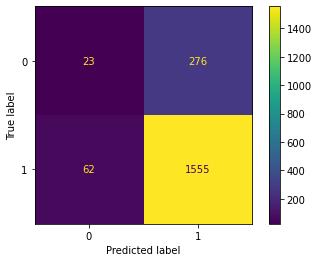

In [12]:
plot_confusion_matrix(knn1 ,X_test, y_test)

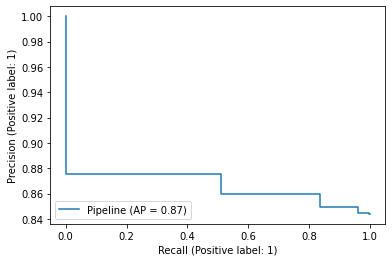

In [13]:
plot_precision_recall_curve(knn1 ,X_test, y_test)

# Unbalanced Model With Hyperparameter Tuning

*for knn do i need hyperparameter tuning? Should use grid search for number of neighbors*

In [14]:
params = {
    'knn_classifier__weights':['uniform', 'distance'],
    'knn_classifier__n_neighbors':[2,3,5,7,10]
}

grid1 = GridSearchCV(knn1,params,scoring='f1')
grid1.fit(X_train,y_train)
grid1.best_params_

{'knn_classifier__n_neighbors': 10, 'knn_classifier__weights': 'distance'}

In [15]:
grid1.best_score_

0.9089202801588229

In [16]:
print_scores(grid1, X_test, y_test)

precision score:  0.9789734075448361
recall score:  0.8451681793913508
f1 score:  0.907163323782235
--------------------------------------------------
The percentage of fully_paid predicted correctly:  97.89734075448361
The percentage of not fully_paid predicted correctly:  3.0100334448160537


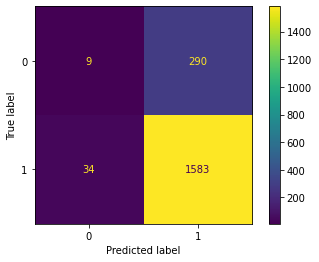

In [17]:
plot_confusion_matrix(grid1 ,X_test, y_test)

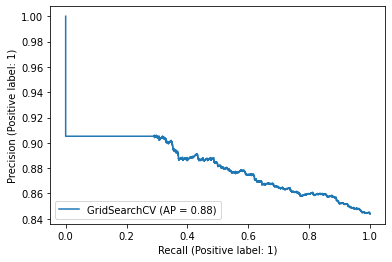

In [18]:
plot_precision_recall_curve(grid1 ,X_test, y_test)

# Model with undersampling and hyperparameter tuning

In [19]:
knn2 = imbPipeline(steps =[
    ('preprocessor',preprocessor),
    ('sampler',RandomUnderSampler(random_state=625)),
    ('knn_classifier', KNeighborsClassifier())])

In [20]:
# scoring=make_scorer(fbeta_score,beta=0.5)
grid2 = GridSearchCV(knn2,params,scoring='f1')
grid2.fit(X_train,y_train)
grid2.best_params_

{'knn_classifier__n_neighbors': 10, 'knn_classifier__weights': 'distance'}

In [21]:
grid2.best_score_

0.7254177481585282

In [22]:
print_scores(grid2, X_test, y_test)

precision score:  0.6376004947433519
recall score:  0.8744698897370653
f1 score:  0.7374821173104434
--------------------------------------------------
The percentage of fully_paid predicted correctly:  63.76004947433519
The percentage of not fully_paid predicted correctly:  50.50167224080268


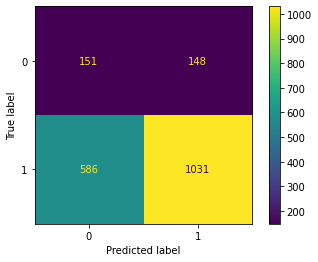

In [23]:
plot_confusion_matrix(grid2, X_test, y_test)

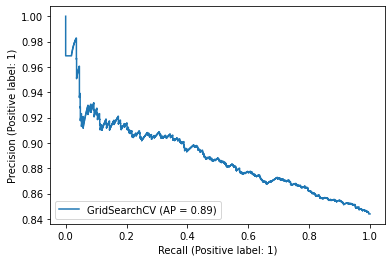

In [24]:
plot_precision_recall_curve(grid2 ,X_test, y_test)

# Model with oversampling and hyperparameter tuning

In [25]:
knn3 = imbPipeline(steps =[
    ('preprocessor',preprocessor),
    ('sampler',RandomOverSampler(random_state=625)),
    ('knn_classifier', KNeighborsClassifier())])

In [26]:
grid3 = GridSearchCV(knn3,params,scoring='f1')
grid3.fit(X_train,y_train)
grid3.best_params_

{'knn_classifier__n_neighbors': 2, 'knn_classifier__weights': 'distance'}

In [27]:
grid3.best_score_

0.863226039369418

In [28]:
print_scores(grid3, X_test, y_test)

precision score:  0.8559059987631417
recall score:  0.847001223990208
f1 score:  0.8514303291294987
--------------------------------------------------
The percentage of fully_paid predicted correctly:  85.59059987631416
The percentage of not fully_paid predicted correctly:  16.387959866220736


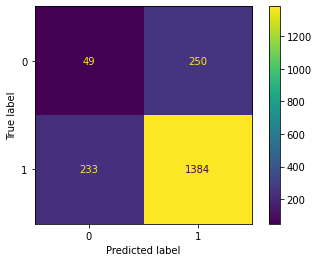

In [29]:
plot_confusion_matrix(grid3,X_test,y_test)

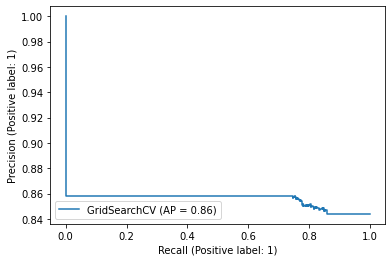

In [30]:
plot_precision_recall_curve(grid3 ,X_test, y_test)

In [ ]:
# need to figure out if you want to use fbeta score.